### Torus Geometry
- **Triangular unit cell**: Primitive vectors G₁ = (G, 0), G₂ = (-G/2, √3G/2)
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Filling Factor
- **ν**: Filling factor 1/3 or others (Laughlin state)
- **Nk**: Number of k-points must be multiple of m for commensurability
- **Ne = Nk * ν**: Number of electrons for ν filling

### Interaction Details
- **Form factor**: V(q) = W₀ × 1/|ql| × tanh(|qD|)
- **Screening**: D/l (finite screening length)
- **Landau level projection**: exp(-0.5 × q²l²) form factor
- **Units**: Energy in units of W₀, length in units of magnetic length l

### Key Physics
- **Magnetic translation algebra**: Implements proper commutation relations
- **Periodic boundary conditions**: Torus geometry with modular parameter τ
- **Momentum conservation**: Total momentum K = (K₁, K₂) is conserved
- **Ground state degeneracy**: m-fold degenerate on torus for Laughlin states

In [ ]:
# Define k-mesh for triangular lattice
# Using 3×5 mesh (Nk=15) for accurate Laughlin state calculation
# Note: Nk must be multiple of m=3 for 1/3 filling factor
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)      # Grid dimensions (G1_direction, G2_direction)
Ne = 5         # N electrons for this system

In [ ]:
# Define k-mesh for triangular lattice
# Using 9×9 mesh (Nk=27) for accurate Laughlin state calculation
# Note: This setup needsmuch more time and memory

#=

k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]

# System parameters
Nk = 27          # Total number of k-points
Gk = (9, 9)      # Grid dimensions (G1_direction, G2_direction)
@assert iszero(mod(Nk, 3))  # Ensure commensurability
m = 3            # Denominator of filling factor ν = 1/m
# Number of electrons for 1/3 filling
Ne = Nk ÷ m      # N electrons for this system

=#

In [ ]:
# Import the momentum-conserved exact diagonalization package
using MomentumED

# Physical parameters for the FQH system
Gl = sqrt(2π/sqrt(0.75))  # Magnetic length scale from Brillouin zone area
D_l = 5.0                  # Screening length / magnetic length (D/l = 5)
W0 = 1.0                   # Interaction strength (energy unit)
G12_angle = 2π/3          # Angle between reciprocal lattice vectors (triangular lattice)

# Define the form factor for Coulomb interaction in Landau level
# This is the Fourier transform of the projected Coulomb interaction
# V(q) = W₀ * 1/|ql| * tanh(|qD|) * exp(-0.5 * q²l²)
# The exp(-0.5 * q²l²) factor comes from Landau level projection
function VFF(q1::Float64, q2::Float64)
    ql = sqrt(q1^2 + q2^2 + 2cos(G12_angle) * q1*q2) * Gl  # |q| in magnetic length units
    if ql == 0.0
        return W0 * D_l  # Regularization at q=0 (divergent part)
    end
    return W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
end

# Sign function for reciprocal lattice vectors
# This implements the phase structure of the magnetic translation group
# The sign depends on the parity of the reciprocal lattice vector indices
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end

# Cross product for 2D vectors (returns scalar z-component)
# Used for computing geometric phases in the magnetic translation algebra
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end

# Two-body interaction matrix element
# This implements the full Coulomb interaction with proper magnetic translation phases
# The interaction is computed in momentum space with Landau level projection
# Momentum inputs are Tuple(Float64, Float64) representing (k1, k2) in ratio of Gk
function V_int(kf1, kf2, ki1, ki2, cf1=1, cf2=1, ci1=1, ci2=1; output=false)::ComplexF64
    
    # Calculate momentum transfer (modulo reciprocal lattice)
    q = rem.(ki1 .- kf1, 1, RoundNearest)
    G_shift1 = round.(Int64, ki1 .- kf1 .- q, RoundNearest)
    G_shift2 = round.(Int64, kf2 .- ki2 .- q, RoundNearest)

    V_total = ComplexF64(0.0)
    # Sum over reciprocal lattice vectors for convergence
    # Nshell = 2 provides good convergence for this system
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        # Construct the full momentum transfer including reciprocal lattice
        qq1 = q[1] + g1
        qq2 = q[2] + g2

        # Calculate phase factors from magnetic translation algebra
        # These phases ensure proper commutation relations and gauge invariance
        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        V_total += sign * phase * VFF(qq1, qq2)
    end

    return V_total
end

# Create parameter structure for the exact diagonalization
# This contains all the system information needed for the calculation
para = EDPara(k_list=k_list, Gk=Gk, V_int = V_int);

In [4]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
length.(blocks)

15-element Vector{Int64}:
 335
 335
 335
 335
 335
 333
 333
 333
 333
 333
 333
 333
 333
 333
 333

In [5]:
scat_list1 = ED_sortedScatteringList_onebody(para);
scat_list2 = ED_sortedScatteringList_twobody(para);

In [6]:
energies = Vector{Vector{Float64}}(undef, length(blocks))
Neigen = 10
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i] = EDsolve(blocks[i], scat_list1, scat_list2, Neigen;
    showtime=true, converge_warning = false)[1]
end

Processing block #1 with size 335, momentum 0, 0
  0.245524 seconds (571.91 k allocations: 18.765 MiB, 1.81% gc time, 528.04% compilation time)
  0.332400 seconds (730.94 k allocations: 40.601 MiB, 1.05% gc time, 268.72% compilation time)
Processing block #2 with size 335, momentum 0, 1
  0.008384 seconds (372.40 k allocations: 8.893 MiB, 29.31% gc time)
  0.005730 seconds (4.25 k allocations: 3.061 MiB)
Processing block #3 with size 335, momentum 0, 2
  0.008588 seconds (372.42 k allocations: 8.893 MiB, 31.84% gc time)
  0.006330 seconds (4.49 k allocations: 3.241 MiB)
Processing block #4 with size 335, momentum 0, 3
  0.008122 seconds (372.45 k allocations: 8.893 MiB, 7.77% gc time)
  0.007587 seconds (4.50 k allocations: 3.241 MiB, 7.19% gc time)
Processing block #5 with size 335, momentum 0, 4
  0.006727 seconds (372.39 k allocations: 8.893 MiB, 8.12% gc time)
  0.009222 seconds (4.25 k allocations: 3.060 MiB)
Processing block #6 with size 333, momentum 1, 0
  0.006735 seconds (370

In [7]:
# The package for plotting is not included in this package. Use the following to add it:
# using Pkg; Pkg.add("CairoMakie")

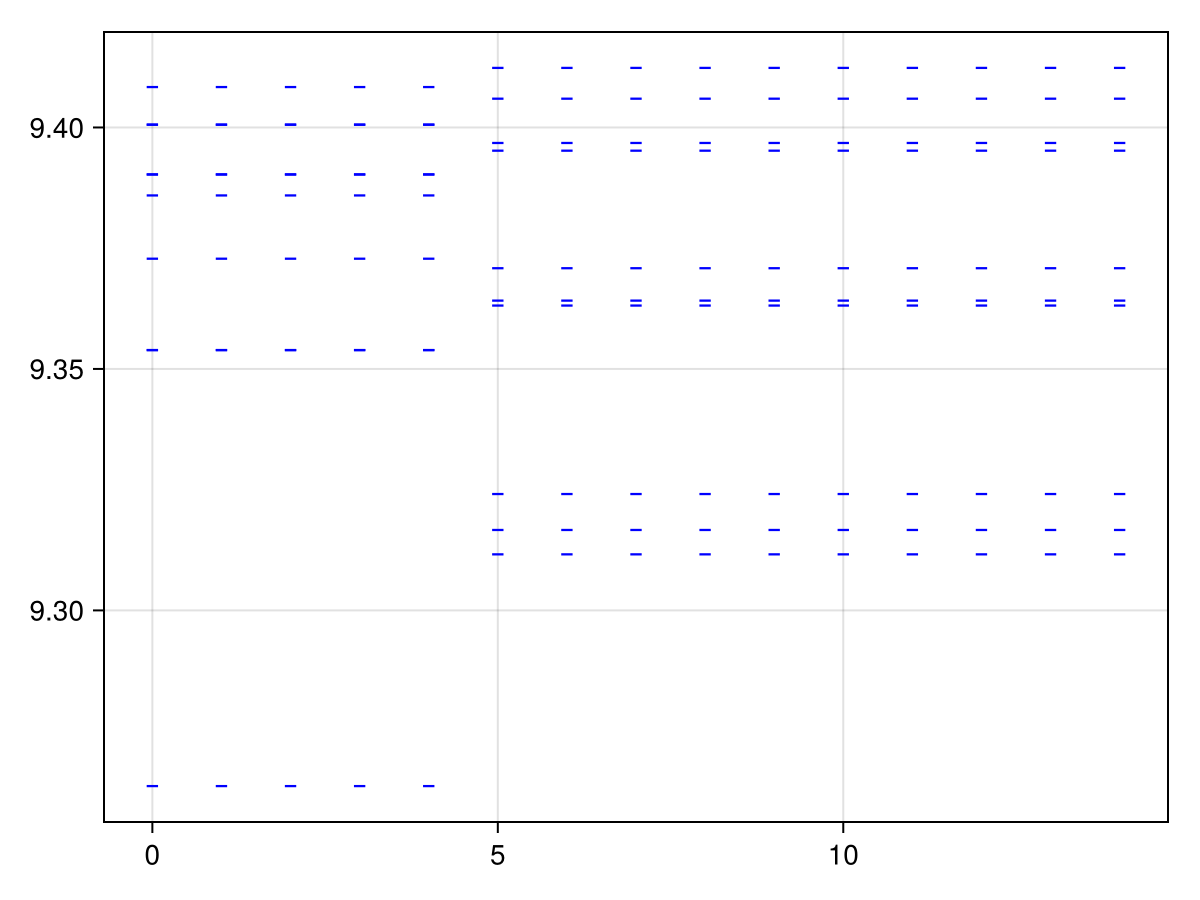

In [8]:
# Plot the energy spectrum
using CairoMakie
CairoMakie.activate!()
begin
    fig = Figure();
    ax = Axis(fig[1, 1])
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, Gk[2]*block_k1[i]+block_k2[i], e, color = :blue, marker=:hline)
        end
    end
    fig
end

In [9]:
# check energies explicitly to see if there's degeneracy in the same momentum sector.
energies[1]

10-element Vector{Float64}:
 9.263613237081834
 9.353897602425608
 9.35389760242565
 9.372820253455643
 9.385920087106026
 9.390267355605557
 9.390267355605587
 9.40057694533967
 9.400576945339678
 9.408363616226888